In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns
import xarray as xr

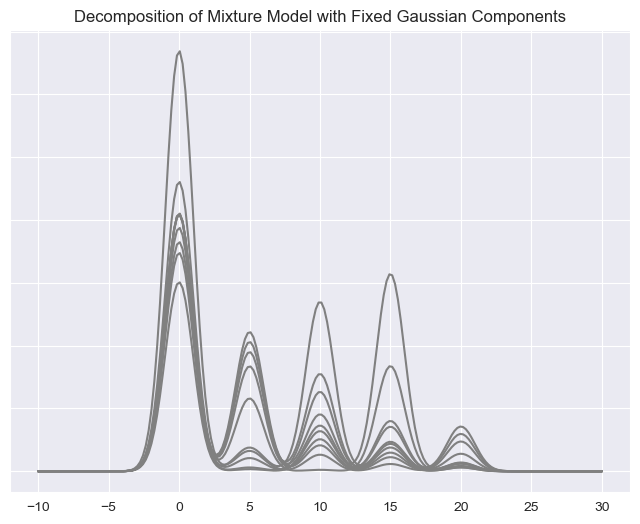

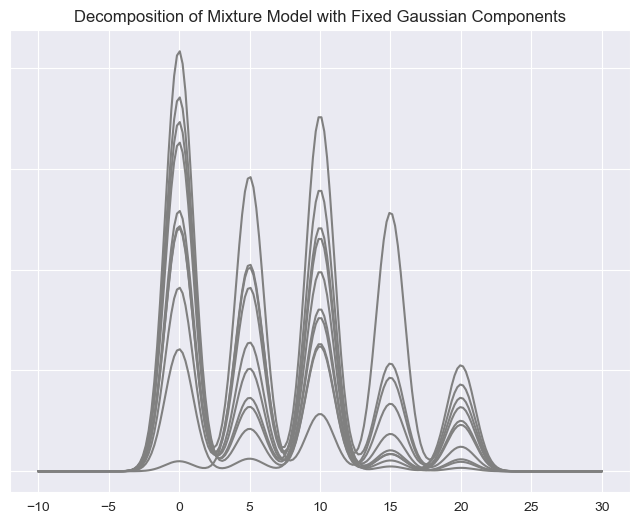

In [3]:
# Parameters
N = 10
K = 5  # Now K corresponds to the number of Gaussian components
alpha = 2
means = np.array([0, 5, 10, 15, 20])
variance = 1
P0 = sp.stats.norm

# Setting up the mixture model with fixed means
f = lambda x, theta: sp.stats.norm.pdf(x, theta, np.sqrt(variance))
x_plot = xr.DataArray(np.linspace(-10, 30, 200), dims=["plot"])

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

# Using fixed means for the components
theta = np.tile(means, (N, 1))

dpm_pdf_components = f(x_plot, theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c="gray")

ax.set_yticklabels([])
plt.title("Decomposition of Mixture Model with Fixed Gaussian Components")
plt.show()

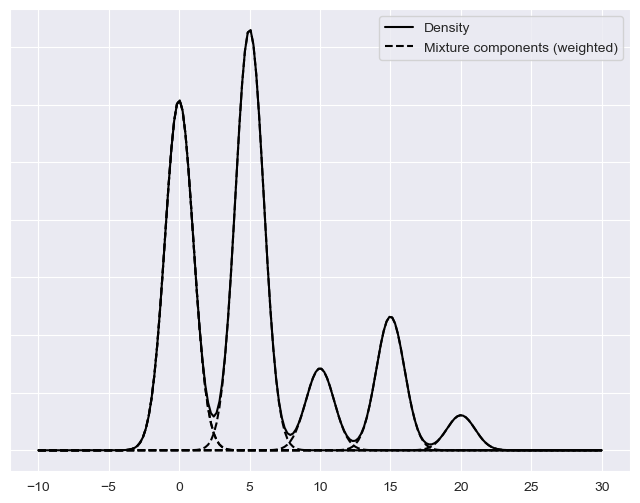

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c="k", label="Density")
ax.plot(
    x_plot,
    (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
    "--",
    c="k",
    label="Mixture components (weighted)",
)
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T, "--", c="k")

ax.set_yticklabels([])
ax.legend(loc=1);

In [5]:
try:
    old_faithful_df = pd.read_csv(os.path.join("..", "data", "old_faithful.csv"))
except FileNotFoundError:
    old_faithful_df = pd.read_csv(pm.get_data("old_faithful.csv"))


old_faithful_df["std_waiting"] = (
    old_faithful_df.waiting - old_faithful_df.waiting.mean()
) / old_faithful_df.waiting.std()


old_faithful_df.head()

,eruptions,waiting,std_waiting
0,3.600,79,0.596025
1,1.800,54,-1.242890
2,3.333,74,0.228242
3,2.283,62,-0.654437
4,4.533,85,1.037364


# Now we do experiments as we did before in sci-kit learn

In [6]:
np.random.seed(0)
n_samples = 500

# Means for the four clusters
means = [0, 5, 10, 15, 20]

# Variance (standard deviation squared) for all clusters
variance = 1

# Generate samples
data = []
for mean in means:
    data.append(np.random.normal(mean, np.sqrt(variance), n_samples // len(means)))

# Concatenate all data into a single array
data = np.concatenate(data).reshape(-1, 1)

# Turn data into DataFrame
sampled_data = pd.DataFrame(data, columns=['Value'])

sampled_data.head()  # Display the first few rows of the DataFrame

,Value
0,1.764052
1,0.400157
2,0.978738
3,2.240893
4,1.867558


In [7]:
N = sampled_data.shape[0]
K = 30

In [8]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [9]:
with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1.0, alpha, dims="component")
    w = pm.Deterministic("w", stick_breaking(beta), dims="component")

    tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
    lambda_ = pm.Gamma("lambda_", 10.0, 1.0, dims="component")
    mu = pm.Normal("mu", 0, tau=lambda_ * tau, dims="component")
    obs = pm.NormalMixture(
        "obs", w, mu, tau=lambda_ * tau, observed=sampled_data.Value.values, dims="obs_id"
    )

In [10]:
RANDOM_SEED = 42

with model:
    trace = pm.sample(
        tune=2500,
        init="advi",
        target_accept=0.975,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 89100
Interrupted at 89,099 [44%]: Average Loss = 4,355.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 510 seconds.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


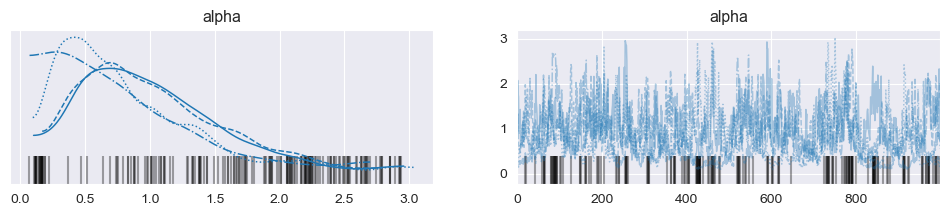

In [11]:
az.plot_trace(trace, var_names=["alpha"]);

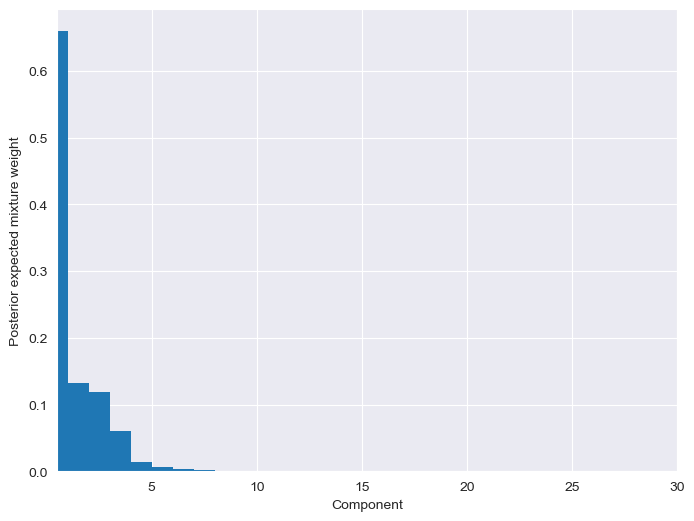

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace.posterior["w"].mean(("chain", "draw")), width=1.0, lw=0)

ax.set_xlim(0.5, K)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");

In [13]:
post_pdf_contribs = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    trace.posterior["mu"],
    1.0 / np.sqrt(trace.posterior["lambda_"] * trace.posterior["tau"]),
)

post_pdfs = (trace.posterior["w"] * post_pdf_contribs).sum(dim=("component"))

post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))

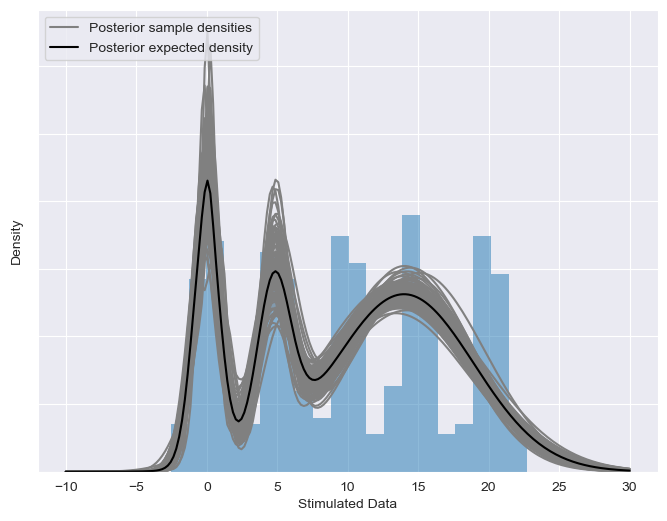

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(sampled_data.Value.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.fill_between(
    x_plot,
    post_pdf_quantiles.sel(quantile=0.1),
    post_pdf_quantiles.sel(quantile=0.9),
    color="gray",
    alpha=0.45,
)
ax.plot(x_plot, post_pdfs.sel(chain=0, draw=0), c="gray", label="Posterior sample densities")
ax.plot(
    x_plot,
    az.extract(post_pdfs, var_names="x", num_samples=100),
    c="gray",
)
ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")

ax.set_xlabel("Stimulated Data")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

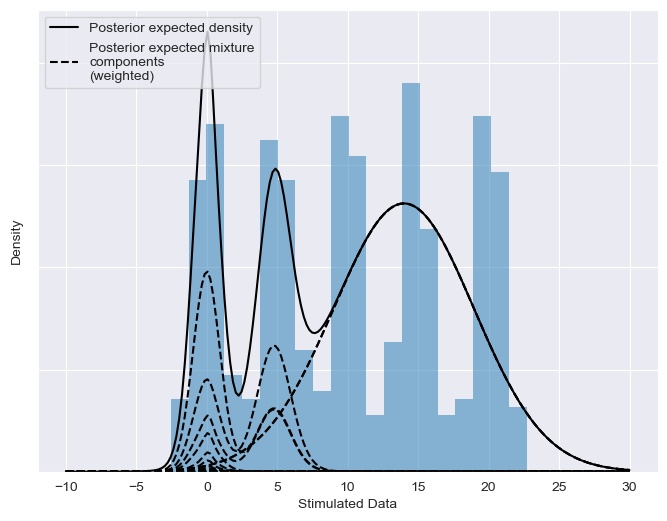

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(sampled_data.Value.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).sel(component=0),
    "--",
    c="k",
    label="Posterior expected mixture\ncomponents\n(weighted)",
)
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).T,
    "--",
    c="k",
)

ax.set_xlabel("Stimulated Data")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

# Now we do experiments on different variance

In [16]:
np.random.seed(0)
n_samples = 500
variances = [1, 2, 3, 4, 5, 6, 7]
datas = []
for variance in variances:
    data = []
    for mean in means:
        data.append(np.random.normal(mean, np.sqrt(variance), n_samples // len(means)))

    # Concatenate all data into a single array
    data = np.concatenate(data).reshape(-1)

    datas.append(data)

In [21]:
models = []
traces = []

def train_model(data):
    with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
        alpha = pm.Gamma("alpha", 1.0, 1.0)#
        beta = pm.Beta("beta", 1.0, alpha, dims="component")
        w = pm.Deterministic("w", stick_breaking(beta), dims="component")

        tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
        lambda_ = pm.Gamma("lambda_", 10.0, 1.0, dims="component")
        mu = pm.Normal("mu", 0, tau=lambda_ * tau, dims="component")
        obs = pm.NormalMixture(
            "obs", w, mu, tau=lambda_ * tau, observed=data, dims="obs_id"
        )
        RANDOM_SEED = 42

    with model:
        trace = pm.sample(
            tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,
        )
    return trace, model

for data in datas:
    trace, model = train_model(data)
    traces.append(trace)
    models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 89100
Interrupted at 89,099 [44%]: Average Loss = 4,355.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 525 seconds.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 97200
Interrupted at 97,199 [48%]: Average Loss = 4,047.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 305 seconds.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 90900
Interrupted at 90,899 [45%]: Average Loss = 4,218.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 476 seconds.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 87600
Interrupted at 87,599 [43%]: Average Loss = 4,271.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 550 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 87600
Interrupted at 87,599 [43%]: Average Loss = 4,251.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 635 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 91100
Interrupted at 91,099 [45%]: Average Loss = 4,128.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 548 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 103800
Interrupted at 103,799 [51%]: Average Loss = 3,914.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 322 seconds.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


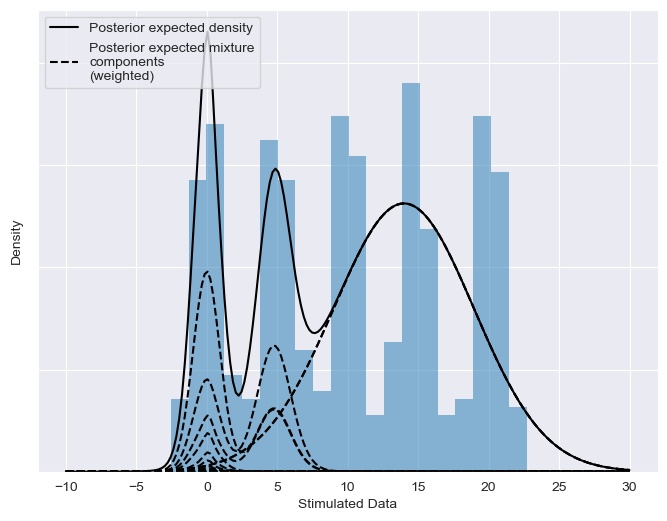

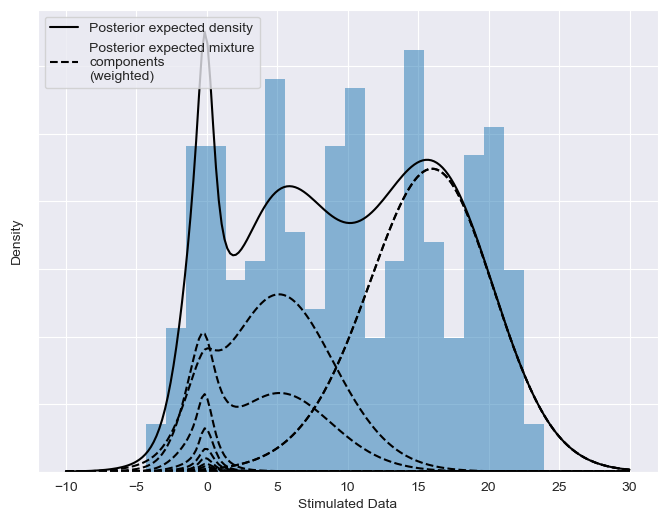

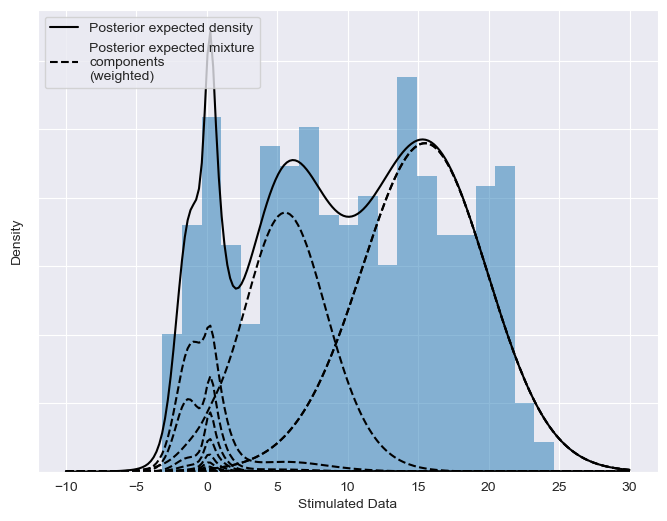

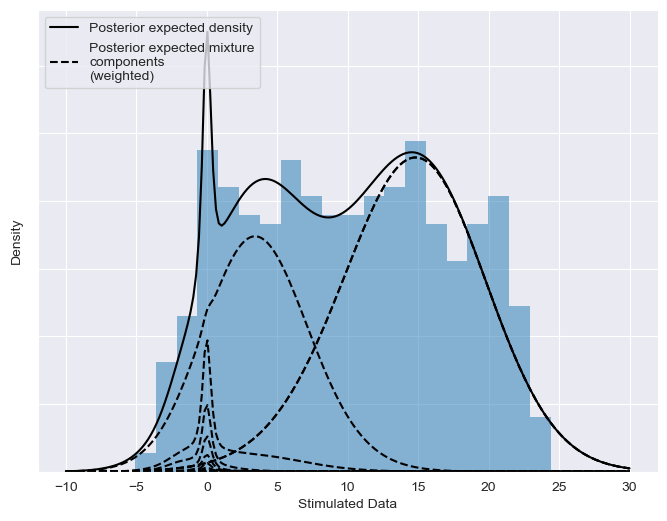

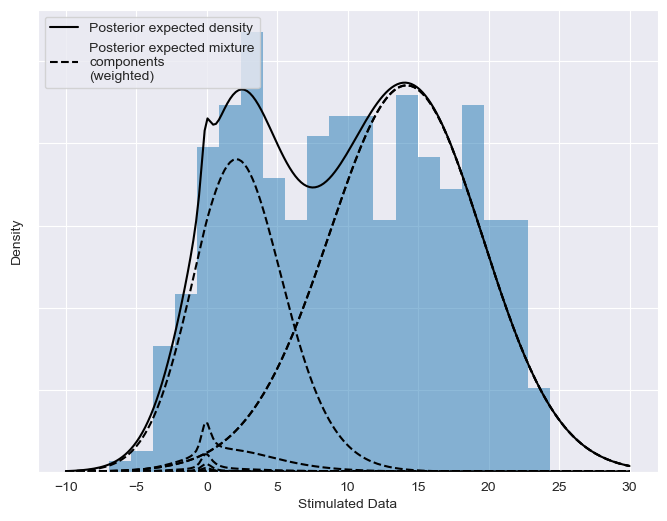

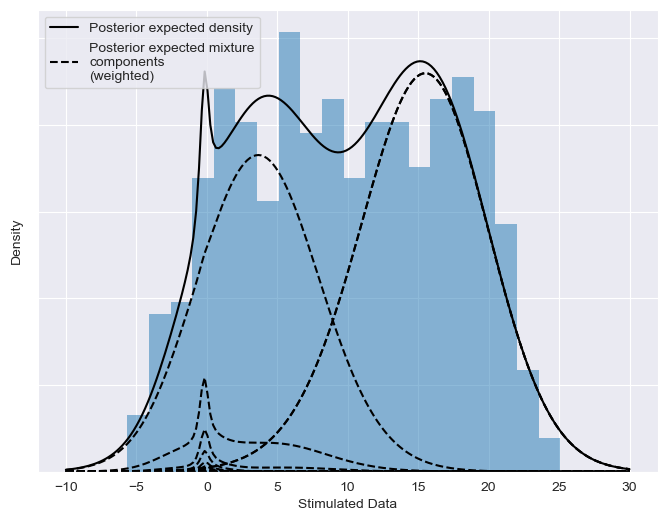

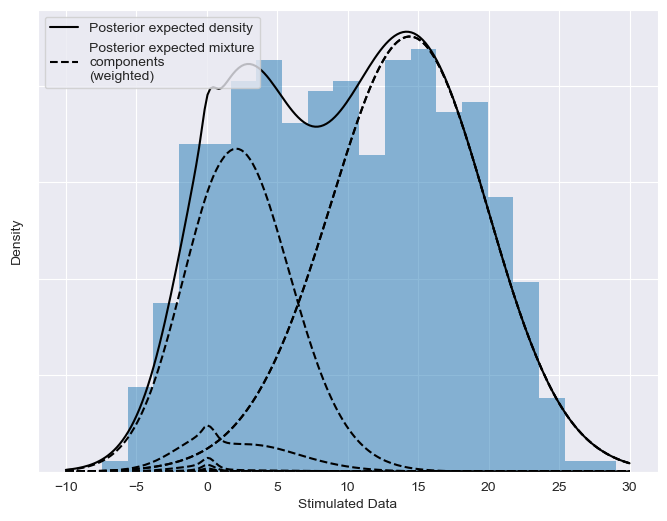

In [20]:
for model, data in zip(traces, datas):
    post_pdf_contribs = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    model.posterior["mu"],
    1.0 / np.sqrt(model.posterior["lambda_"] * model.posterior["tau"]),
)

    post_pdfs = (model.posterior["w"] * post_pdf_contribs).sum(dim=("component"))

    post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))

    fig, ax = plt.subplots(figsize=(8, 6))

    n_bins = 20
    ax.hist(data, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

    ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
    ax.plot(
        x_plot,
        (model.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).sel(component=0),
        "--",
        c="k",
        label="Posterior expected mixture\ncomponents\n(weighted)",
    )
    ax.plot(
        x_plot,
        (model.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).T,
        "--",
        c="k",
    )

    ax.set_xlabel("Stimulated Data")

    ax.set_yticklabels([])
    ax.set_ylabel("Density")

    ax.legend(loc=2);

# Now we stimulate the data using fitted model

In [58]:
# Simulating new data from the posterior
simulated_data = []
for model, trace in zip(models, traces):
    with model:
        posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=42)
        simulated_data.append(posterior_predictive["posterior_predictive"]["obs"])

Sampling: [obs]


Output()

Sampling: [obs]


Output()

Sampling: [obs]


Output()

Sampling: [obs]


Output()

Sampling: [obs]


Output()

Sampling: [obs]


Output()

Sampling: [obs]


Output()

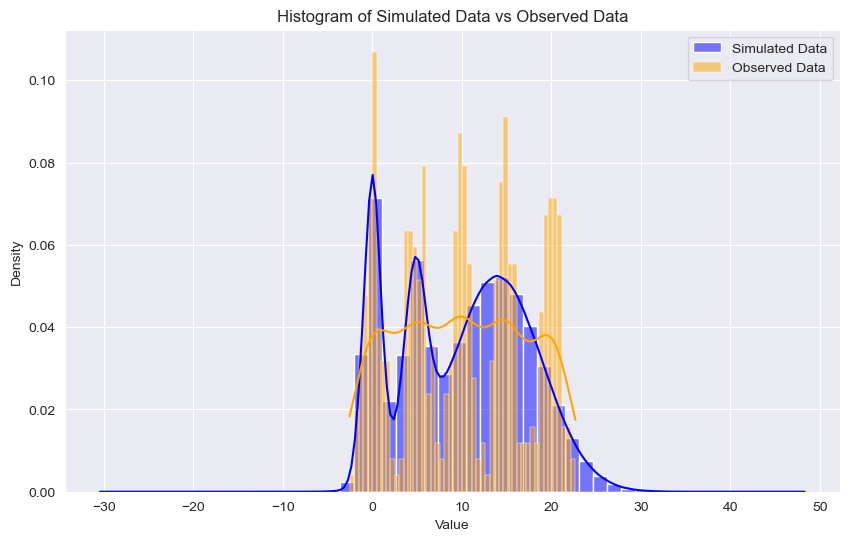

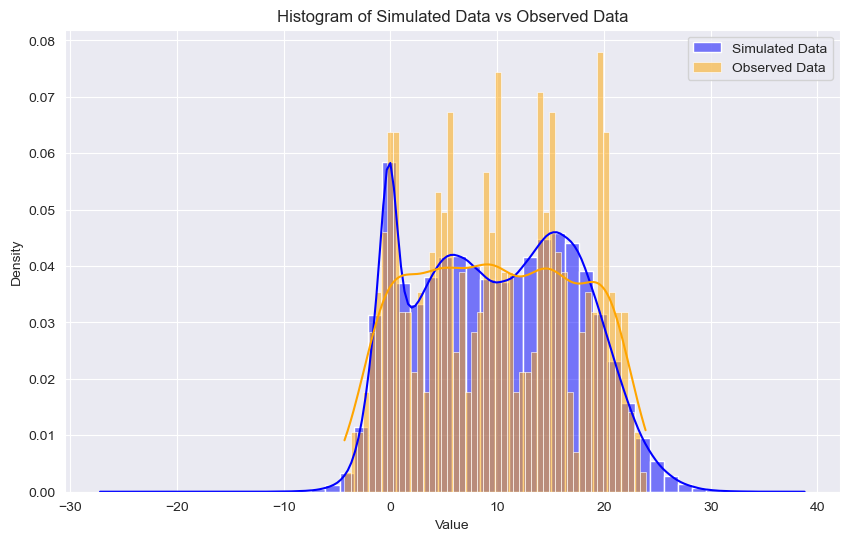

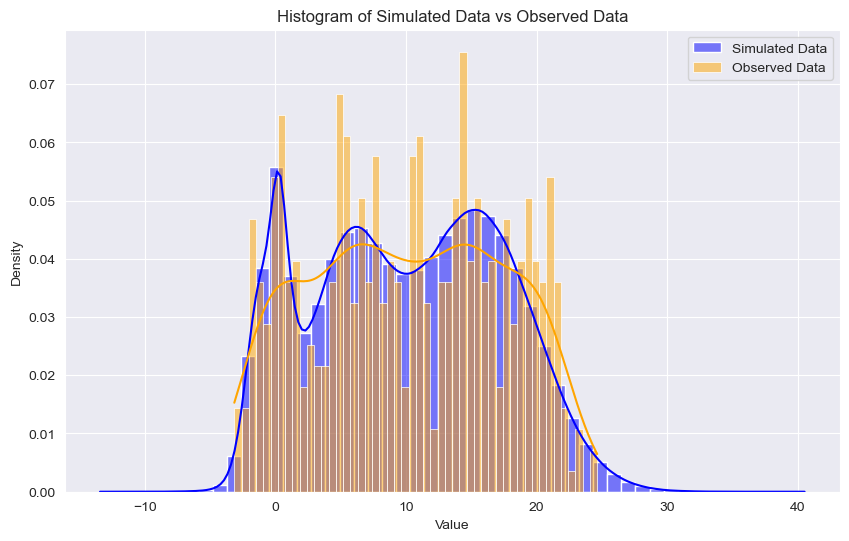

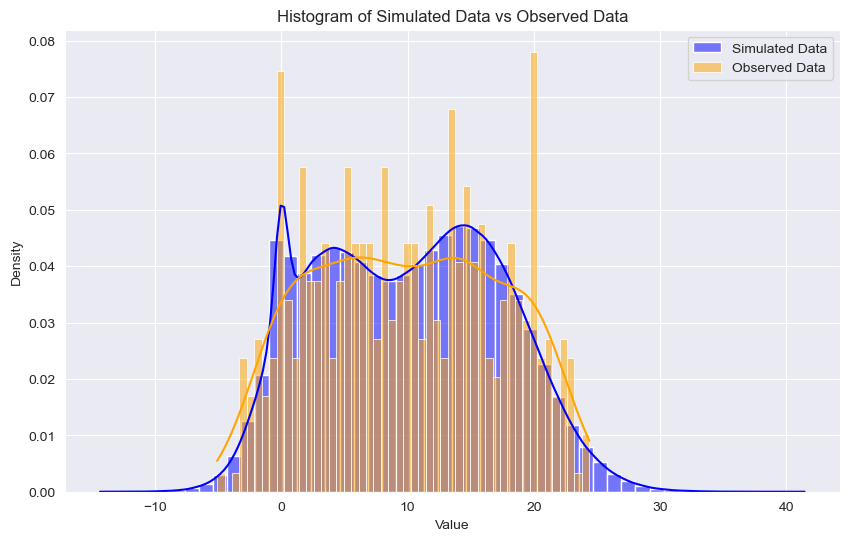

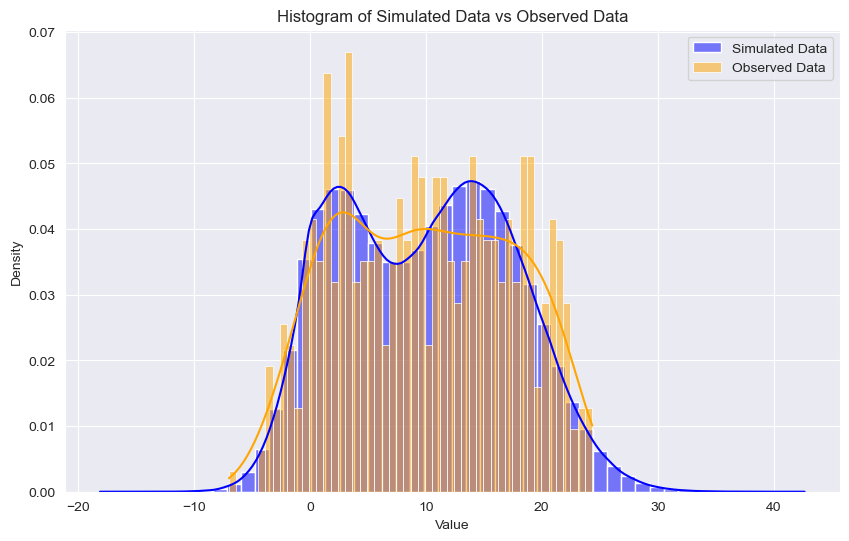

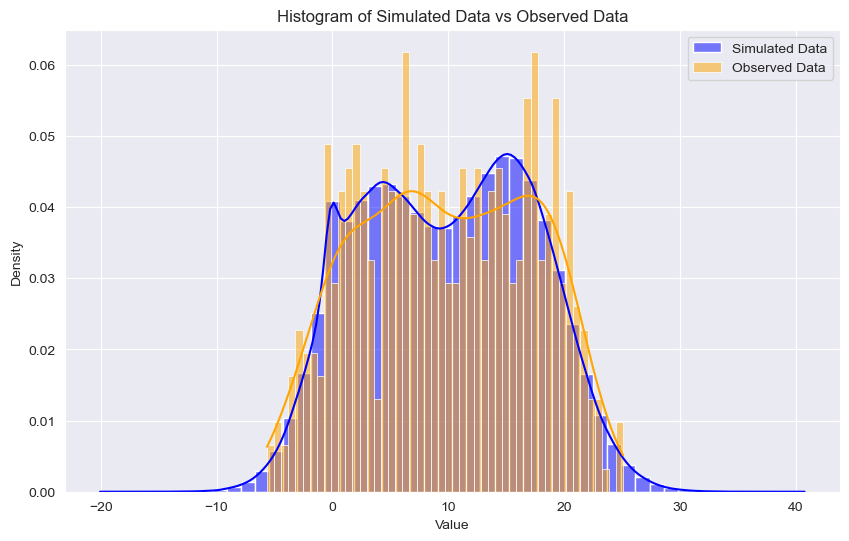

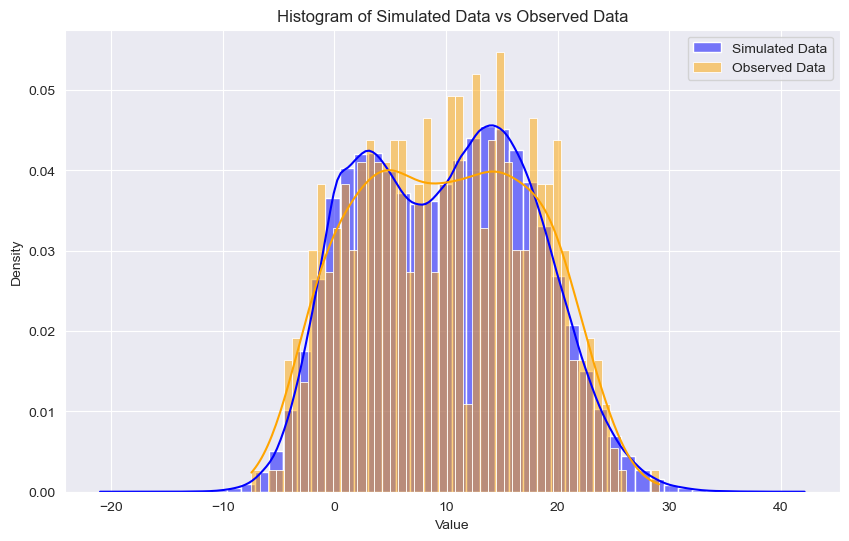

In [59]:
for stimulated,observed_data in zip(simulated_data, datas):
    simulated = stimulated.stack(samples=("chain", "draw")).values.flatten()

    # Plotting the histogram
    plt.figure(figsize=(10, 6))

    # Plot the histogram of the simulated data
    sns.histplot(simulated, bins=50, kde=True, color='blue', label='Simulated Data', stat='density')

    # Plot the histogram of the observed data
    sns.histplot(observed_data, bins=50, kde=True, color='orange', label='Observed Data', stat='density')

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Histogram of Simulated Data vs Observed Data')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

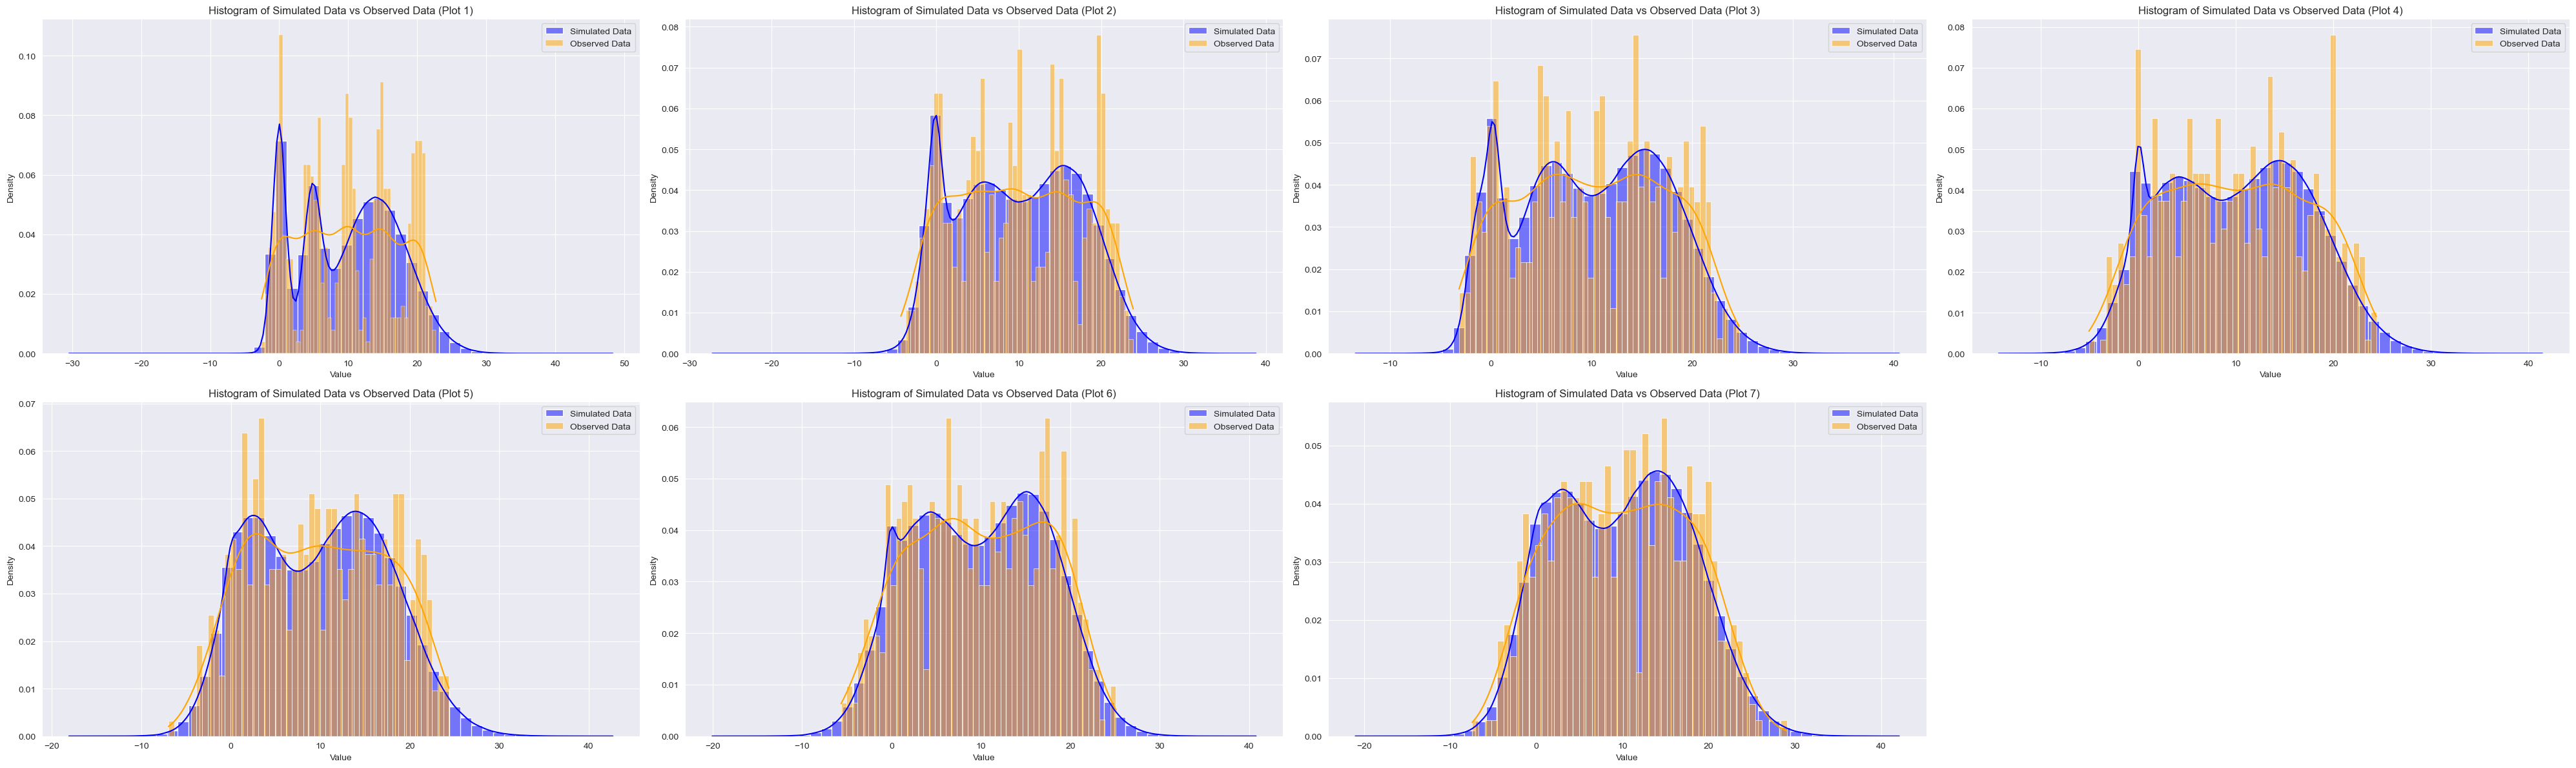

In [73]:

# Number of subplots
num_plots = len(simulated_data)

# Determine the number of columns based on having 2 rows
ncols = (num_plots + 1) // 2  # This ensures there are enough columns to fit all plots

# Create subplots with 2 rows
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(10*ncols, 6*2))

# Flatten axes for easy iteration (even if it's a 2D grid)
axes = axes.flatten()

# Iterate through simulated and observed data, plotting each pair
for i, (stimulated, observed_data) in enumerate(zip(simulated_data, datas)):
    # Flatten the simulated data
    simulated = stimulated.stack(samples=("chain", "draw")).values.flatten()

    # Plot on the corresponding subplot
    ax = axes[i]

    # Plot the histogram of the simulated data
    sns.histplot(simulated, bins=50, kde=True, color='blue', label='Simulated Data', stat='density', ax=ax)

    # Plot the histogram of the observed data
    sns.histplot(observed_data, bins=50, kde=True, color='orange', label='Observed Data', stat='density', ax=ax)

    # Add labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Histogram of Simulated Data vs Observed Data (Plot {i + 1})')

    # Add legend
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()